# Get started
In this tutorial we investigate how to solve single-phase flow in PorePy using a two-point flux approximation.<br>
Let $\Omega$ be a regular domain with boundary $\partial \Omega$. The boundary can be divided in two non-overlapping parts useful to impose Dirichlet ($\partial \Omega_d$) and Neumann ($\partial \Omega_n$) boundary conditions. We indicate with $\mathbf{n}$ the outward unit normal vector of $\partial \Omega$.<br>
The single-phase flow can be written as
$$ - \nabla \cdot K \nabla p = f $$
with boundary conditions on $\partial \Omega_d$ and $\partial \Omega_n$:
$$ p = p_b \qquad - K \nabla p \cdot \mathbf{n} = u_b$$

Where $f \:[\frac{1}{s}]$ is a scalar source/sink term, $K \:[\frac{m^2}{Pa \cdot s}]$ is the permeability matrix, $p_b \: [Pa]$ is the pressure at the boundary (Dirichlet condition), and $u_p \:[\frac{m}{s}]$ is the normal flux at the boundary (Neumann condition).<br>

We present *step-by-step* how to create the grid, declare the problem data, and finally solve the problem. <br><br>

For this example we choose a unit square domain with Dirichlet condition on the bottom boundary and Neumann conditions elsewhere: $\Omega = [0, 1]^2$, $\partial \Omega_d = \partial \Omega|_{y=0}$, $\partial \Omega_n = \partial \Omega\setminus\partial \Omega_d$. The data $f$, $K$, $p_b $ and $u_b$ will be defined below.

## Import modules
Before creating the grid we need access to the following PorePy modules and classes:
* `plot_grid` plots the grid and the solution using Matplotlib;
* `tensor` is used to declare the permeability;
* `BoundaryCondition` handles the information useful for the boundary conditions.
* `Parameters` contains the physical data for the problem.

They are all accessed through the `import porepy as pp` statement. We also use the standard python libraries `numpy` and `scipy.sparse`.

In [1]:
import numpy as np
import scipy.sparse as sps
import porepy as pp

## Creation of the grid
We create a Cartesian grid specifying the number of cells in each direction and the physical size, and compute its geometry.

In [2]:
Nx = Ny = 10                   
g = pp.CartGrid([Nx, Ny], [1, 1])
g.compute_geometry()

To visualize the grid, we use the PorePy module plot_grid. Grids are visualized with the following options for additional information: 
* `info='c'` represents cell information, center and id
* `info='f'` represents face information, center and id
* `info='n'` represents node information, position and id
* `info='o'` represents normal information

A combination of the options is possible, the order is not important. <br>

**Note**: The `info='all'` is equivalent to `info='cfno'`

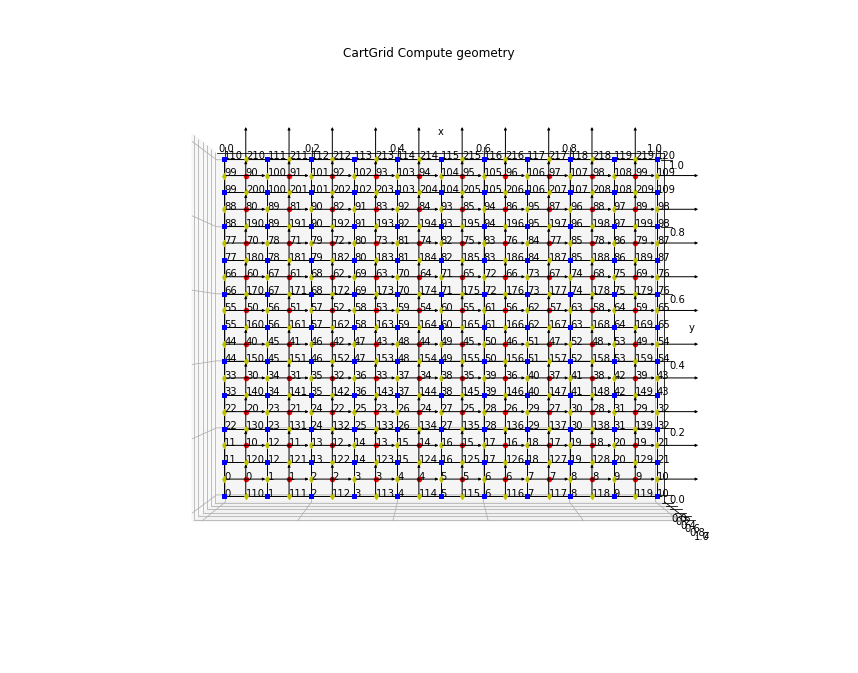

In [6]:
pp.plot_grid(g, info="all", alpha=0, figsize=(15, 12), vector_scale=.1)

# Problem data
All the data in PorePy are piecewise constant in their respective domains (cells or faces).<br>
The simplest way to create an identity tensor is:

In [7]:
perm = pp.SecondOrderTensor(g.dim, np.ones(g.num_cells))

However, we wish to investigate a test case with heterogeneous permeability tensor $K$ and a constant scalar source term. They can be declared as

In [8]:
Omega_1 = g.cell_centers[0, :] < 0.5

kxx = 1e2 * np.ones(g.num_cells)
kyy = np.ones(g.num_cells)
kxy = 8 * np.ones(g.num_cells)
kxx[Omega_1] = np.ones(np.sum(Omega_1))
kyy[Omega_1] = 1e2*np.ones(np.sum(Omega_1))
perm = pp.SecondOrderTensor(g.dim, kxx=kxx, kyy=kyy, kxy=kxy)                              
F = g.cell_volumes

Note that the source term value is set in the cell-wise integrated form, $F=\int_{c_i}f$. This means that the above assignment corresponds to a unitary source term $f = \frac{1}{s}$.

To impose the boundary conditions we need to create an object of the class `BoundaryCondition`. Apart from the grid, it needs the list of the boundary faces and a flag indicating the type of boundary condition:
* `'dir'` for Dirichlet
* `'neu'` for Neumann

The value of the boundary conditions is stored in a vector of lenght `g.num_faces`.<br>
**Note**: The list of face ids needs to be sorted.<br>
**Note**: In the case of mixed boundary conditions only one object is required, the flags need to be ordered according to the second argument of the constructor of `BoundaryCondition`.

In [9]:
b_faces = g.tags['domain_boundary_faces'].nonzero()[0]

labels = np.array(['dir']*b_faces.size)
labels[g.face_centers[1, b_faces] == 1.] = 'neu'

bc = pp.BoundaryCondition(g, b_faces, labels)

bc_val = np.zeros(g.num_faces)
bottom = b_faces[g.face_centers[1, b_faces] == 0.]
bc_val[bottom] = np.ones(bottom.size)

Once all the data are created we use the parameter class to group them. Since we solve a flow problem, we use `'flow'` as key. Finally, we place the parameter object in a dictionary called data, to be passed to the discretizer below.

In [10]:
param = pp.Parameters(g)
param.set_tensor("flow", perm)
param.set_bc("flow", bc)
param.set_bc_val("flow", bc_val)
param.set_source("flow", F)
data = {'param': param}

## Problem solution
PorePy implements a common interface for all numerical schemes: it returns the matrix and the right-hand side given the grid and problem data. <br>

In [12]:
discretizer = pp.Tpfa("flow")
A, b = discretizer.matrix_rhs(g, data)
p = sps.linalg.spsolve(A, b)

`plot_grid` is able to represent piecewise constant solutions, scalar and vector fields, so we now use it to view the pressure solution. The plot shows the influence of both the bottom boundary condition and the heterogeneous permeability tensor.

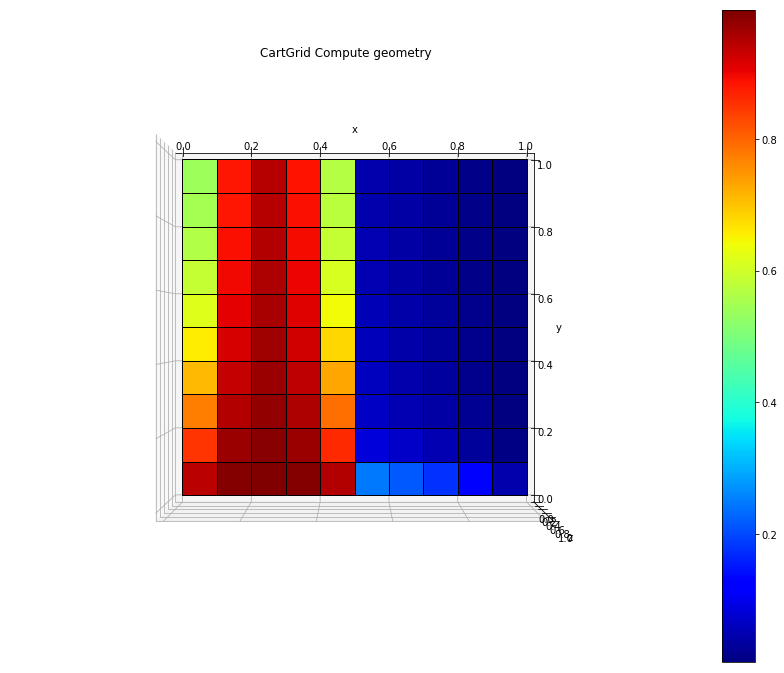

In [13]:
pp.plot_grid(g, p, figsize=(15, 12))

Consistency test with a known solution:

In [14]:
assert np.isclose(pp.error.norm_L2(g, p), 0.6041807238769925)